# Michelle, Erik, and Pauline

Your goal is to perform a sensitivity analysis of the parameters in the fly clock model of Goldbeter. The base project is about determining how consistent the sensitivities are across parameter sets. I would love to see extensions that examine which processes have which effects.

## Instructions
<ol>
<li> Use your genetic algorithm to generate 10 excellent parameter sets (i.e. run the algorithm 10 times and use the lowest cost child from each run). You may use parameter sets you found in Project 4 or you may generate new parameter sets.
<li> For each of the parameter sets, analyze the sensitivity of the amplitude and of the period (separately) to each parameter. To analyze the sensitivity of the amplitude, you will need to choose which state variable to focus on, or use the sensitivity of the sum of the amplitudes. Analyzing the amplitude sensitivities of multiple states and comparing the results is an extension.
<li> What are the similarities and differences in sensitivity across parameter sets? Are there parameters that have opposite effects in different parameter sets? 
</ol>
    
## Extensions
<ol>
<li> Analyze additional models (Pauline/Erik)
<li> Explore the effects of changing the size of the perturbation used to compute the sensitivities. (Michelle)
<li> Include an analysis of the sensitivity of state dynamics to parametric perturbation. (Michelle)
<li> #1 and #2: Analyze additional state variables (Pauline/Erik)
</ol>

## Steps to get you started

### 1. Copy-paste code and/or results from Project 4
You will need the Golbeter's model and get_period at the very least. If you are generating parameter sets in this project, you will also need the GA code and cost function. If you using parameter sets from Project 4, you can just refer to the files that have them (assuming you have .npz file). Save output from .npz file (last project). 

### 2. Write the output functions you want to analyze.
<ol>
<li>Write a function that takes as input the parameters and provides as output the period.
<li>Write a function that takes as input the parameters and provides as output a measurement of the peak-to-trough amplitude. Here is where you can make a decision. You can track the amplitude of one particular state, or sum the amplitudes of all 5 states. In your report, be sure to clearly indicate which you chose.
</ol>

Test them with the published parameters. My output is
<code>
period 23.662222222222223
amplitude of M 2.3759648547322616
amplitude of P0 1.4260629330956047
amplitude of P1 0.7354556871287586
amplitude of P2 0.7550101535148619
amplitude of PN 1.0799752338320783
sum of amplitudes of all states 6.372468862303565</code>

Note: Make sure you run the model for at least 10 days, to eliminate the transient. Then run it again to determine the period or amplitude.

### 3. Write the sensitivity analysis code and test it.

  ## Begin your project here
   
  Complete the project (analyzing the sensitivities) here. If you write extensions, add any support code (e.g. a function to compute the sensitivities to the state dynamics) above. Just concentrate main code for the report here.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import scipy.linalg
from scipy.signal import find_peaks
import scipy.integrate

In [3]:
def gol95_model(t, statevars, params):
    
    M  = statevars[0]; #M
    P0 = statevars[1]; #P0
    P1 = statevars[2]; #P1
    P2 = statevars[3]; #P2
    PN = statevars[4]; #PN
    
    vs = params[0]
    vm = params[1]
    Km = params[2]
    ks = params[3]
    vd = params[4]
    k1 = params[5]
    k2 = params[6]
    KI = params[7]
    Kd = params[8]
    n = params[9]
    K1 = params[10]
    K2 = params[11]
    K3 = params[12]
    K4 = params[13]
    V1 = params[14]
    V2 = params[15]
    V3 = params[16]
    V4 = params[17]
    
    dydt = np.zeros((5,))
    
    dydt[0] = ( vs * ((KI**n)/(KI**n + PN**n)) ) - ( vm * ((M)/(Km + M)) )
    dydt[1] = ks*M - (V1 * ((P0)/(K1+P0))) + (V2 * ((P1)/(K2+P1)))
    dydt[2] = (V1*((P0)/(K1+P0))) - (V2*((P1)/(K2+P1))) - (V3*((P1)/(K3+P1))) + (V4*((P2)/(K4+P2)))
    dydt[3] = (V3*((P1)/(K3+P1))) - (V4*((P2)/(K4+P2))) - (k1*P2) + (k2*PN) - (vd*((P2)/(Kd+P2)))
    dydt[4] = (k1*P2) - (k2*PN)
    
    return dydt

def get_period(arr, t):
    
    peaks, _ = find_peaks(arr)
    time = []
    periods = []
    
    for peak in peaks:
        time.append(t[peak])
    
    for i in range(len(time)-1,0,-1):
        periods.append(time[i] - time[i-1])
        
    return np.mean(periods), np.std(periods)

def gol95_cost( params ):
    
    #Run the simulation with params as the parameters for at least 10 days,
    gol95 = lambda t, y: gol95_model(t, y, params) # how to create params p?
    sol1 = scipy.integrate.solve_ivp(fun=gol95, t_span=(0,480), y0=0.1*np.ones((5,)),  
                                t_eval=np.arange(0,480,0.01))
    
    #Re-run the simulation, beginning with the values from the final time step of the previous simulation.
    sol2 = scipy.integrate.solve_ivp(fun=gol95, t_span=(0,72), y0=sol1.y[:,-1], 
                                t_eval=np.arange(0,72,0.01))
    
    #Compute the period  per  and the cycle-to-cycle standard deviation of the period  sdper 
    per, sdper = get_period(sol2.y[0], sol2.t)
    
    #Compute the cost    
    cost = np.sqrt(((per-23.6)/23.6)**2+(sdper/23.6))
    
    return cost

In [4]:
class GASettings:
    
    def __init__(self, numParents = 10, numChildren = 50):
        self.numParents = numParents;
        self.numChildren = numChildren;
        self.numGenerations = 5;
        self.selection = 'truncation'; 
        self.slope = 15; #for linear ranking selection
        self.tournamentSize = 2;
        self.crossover = 'uniform';
        self.mutation = 0.05; #std of normal distribution computed as mutation*value
        self.eliteCount = 1;
        self.tournamentSize = 2; 
        self.linearRankingRatio = 4;

def select_pool(G, Gcost, settings):
    """ Select a breding pool from the previous generation.
    G is numChildren x numParameters
    Gcost is numChildren long and is sorted in ascending order.
    Returns (P,Pcost)
    where 
    P is numParents x numParameters
    Pcost is numParents long.
    """
    if Gcost.size != settings.numChildren:
        print("problem")
        return
    P = np.zeros( (settings.numParents,G.shape[1]) )
    Pcost = np.zeros( (settings.numParents,) )

    if settings.selection == 'uniform':
        for i in range(settings.numParents):
            idx = np.random.choice(G.shape[0])
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == 'truncation':
        for i in range(settings.numParents):
            idx = np.random.choice(settings.numParents)
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == 'tournament':
        for i in range( settings.numParents ):
            idxs = np.random.choice(G.shape[0], (settings.tournamentSize,) )
            # pick the best one, which is smaller index (since costs sorted)
            idx = idxs.min()
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == 'linearRanking':
        r = settings.linearRankingRatio
        n = settings.numChildren
        pn = 2/n*(1/(1+r))
        p1 = r*pn
        ps = np.zeros((n,))
        for i in range(1,n+1):
            ps[i-1] = pn + (p1-pn)*(n-i)/(n-1)
        cs = ps.cumsum()
        for i in range( settings.numParents ):
            num = np.random.random() # number between 0 and 1, from uniform distribution
            idx = np.argmax( num < cs )
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == 'proportional':
        n = settings.numChildren
        sum_costs = sum(Gcost[:n])
        ps = np.zeros((n,))
        for i in range(0,n):
            ps[i] = Gcost[i]/sum_costs      
        cs = ps.cumsum()
        cs = 1 - cs
        cs.sort()
        for i in range( settings.numParents ):
            num = np.random.random() # number between 0 and 1, from uniform distribution
            idx = np.argmax( num < cs )
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    else:
        print( "Unknown selection operator: ", settings.selection )
    return (P, Pcost)

In [5]:
def generateIndividual(cost_fcn, lb,ub):
    '''
    Generate a viable individual (i.e one whos cost function is finite)
    and return it and its cost.
    If 1000 tries fails to yield an individual, then the paramets and an infinite cost
    are returned.
    Each individual is generated by randomly chosing each entry params[i] 
    so that lb[i] <= params[i] <= ub[i]
    Input:
        cost_fcn: handle to the cost function (which should take a candidate as input)
        lb: lower bounds for parameters (array of length NP)
        ub: upper bounds for parameters (array of length NP)
    Returns:
        (params, cost)
        where params is the same shape as the lower bounds
        and cost is the cost for that set of parameters
    '''
    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range( 1000 ):
        params = lb + np.multiply( np.random.random(lb.size), ub-lb);
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return (params, cost);
    return (params, np.inf)

In [6]:
def generateChild(cost_fcn, P, lb, ub, settings):
    """
    Generate a viable child (i.e one whos cost function is finite)
    and return it and its cost function.
    If 1000 tries fails to yield a parent, then an infinite cost
    is returned.
    Input Parameters:
        cost_fcn: handle to the cost function (which should take a candidate as input)
        P: parents (lam x NP ndarray of parameter values)
        lb: lower bounds for parameters (array of length NP)
        ub: upper bounds for parameters (array of length NP)
        settings: a GASettings object
    Returns:
        (params, cost)
        where params is the same shape as the lower bounds
        and cost is the cost for that set of parameters
    """
    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range(1000):
        # Choose two parenst from the breeding pool.
        P1idx = np.random.choice(P.shape[0]);
        P1  = P[P1idx,:];
        P2idx = np.random.choice(P.shape[0]);
        P2  = P[P2idx,:];
        for j in range(lb.size):
            # uniform cross-over
            if np.random.random() < 0.5:
                params[j] = P1[j];
            else:
                params[j] = P2[j];
        # Mutate optimization variables
        params = np.multiply( 1+np.random.randn(params.size)*settings.mutation, params);
        # Make sure the mutation hasn't moved us out of bounds
        params = np.maximum(params,lb);
        params = np.minimum(params,ub);
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return ( params, cost );
    return (np.zeros((lb.size)), np.inf)

In [7]:
def GA(cost_fcn, lb, ub, settings):
    """ Run the algorithm described in the notes to find a low-cost
        population of parameter sets.
        Input:
            cost_fcn: handle to cost function (should take a paramer set as input)
            lb: lower bounds for parameters (numpy array of length NP)
            ub: lower bounds for parameters (numpy array of length NP)
            settings: GASettings object
        Returns
            (params, cost, all_params, all_costs)
            where 
            params is a 1xNP vector with the best parameter set found
            cost is a scalar with the cost of the best parameter set
            all_params is a list with a (settings.numChildren x NP) ndarray of parameters for each generation
            all_costs is a list with an NP-length array of costs for each generation
    """

    mu = settings.numParents;
    lam = settings.numChildren;
    numGenerations = settings.numGenerations;

    # Create initial population
    G = np.zeros( (lam,lb.size) );
    Gcost = np.zeros( (lam,) );
    for i in range(lam):
        (G[i,:], Gcost[i]) = generateIndividual(cost_fcn, lb, ub);
        
    # Sort them by cost
    idx   = np.argsort(Gcost);
    Gcost = Gcost[idx]
    G     = G[idx,:];
    all_params = [G]
    all_costs = [Gcost]
    mean_gen_cost = []
    median_gen_cost=[]

    for g in range(numGenerations):
        # Promote any elites
        elites = G[:settings.eliteCount,:]
        eliteCosts = Gcost[:settings.eliteCount]
        # select breeding pool
        (P, Pcost) = select_pool( G, Gcost, settings )
        # Generate the children for generation g
        G = np.zeros((lam, lb.size));
        Gcost = np.zeros((lam,));
        G[:settings.eliteCount,:] = elites
        Gcost[:settings.eliteCount] = eliteCosts
        for i in range(settings.eliteCount,lam):
           (G[i,:], Gcost[i]) = generateChild(cost_fcn, P, lb, ub, settings); 
        # sort the children of this generation
        idx   = np.argsort(Gcost);
        Gcost = Gcost[idx]
        G     = G[idx,:];
        print('Best of generation ', g+1, ' has cost ', Gcost[0]);
        all_params.append(G)
        all_costs.append(Gcost)
        mean_gen_cost.append(np.mean(Gcost))
        median_gen_cost.append(np.median(Gcost)) # EXTENSION - Pauline

    params = G[0,:];
    cost   = Gcost[0];
    return (params, cost, all_params, all_costs, mean_gen_cost, median_gen_cost)

In [8]:
#Takes as input the parameters and provides as output the period.
def simulate_gol95(params, t0=0, tStop=240, dt=0.1):
    """ Simulate the Golbeter's model with the given parameters
        at the given time steps and return the solution record. """
    yinit = np.ones((5,));
    gol95 = lambda t, statevars: gol95_model(t, statevars, params)
    sol = scipy.integrate.solve_ivp(fun=gol95, t_span=(0,10*24), y0=yinit, method='RK45', 
                                    t_eval=np.arange(0,10*24,0.1) )

    gol95_2 = lambda t, statevars: gol95_model(t, statevars, params)
    sol = scipy.integrate.solve_ivp(fun=gol95_2, t_span=(0,10*24), y0=sol.y[:,-1], method='RK45', 
                                    t_eval=np.arange(t0,tStop,dt), rtol=1e-8 )

    return sol

def gol95_period( params ):
    """ Simulate the Golbeter's model with the given parameters
        and return the period (a scalar) """
    sol = simulate_gol95( params )
    (per,sdper) = get_period(sol.y[0,:], sol.t)
    return per

def gol95_amplitude( params, which_state=-1 ):
    """ Return the amplitude of the given state or of the sum of all five states
        If which_state  == -1, then return the sum of all 5.
        Otherwise, which_state should be 0 (for M), 1 (for P), or 2 (for I)
    """
    sol = simulate_gol95( params )
    if which_state == -1:
        return np.sum(sol.y.max(axis=1)-sol.y.min(axis=1))
    else:
        return sol.y[which_state,:].max() - sol.y[which_state,:].min()

In [9]:
def sensitivity( fcn, ref_params, frac_change ):
    """
    fcn should be a handle to a function that takes a parameter set as input
        and returns a scalar as output.
    ref_params should be a 1D ndarray with the parameter set
    frac_change is the perturbation size, as a scale (i.e. the fraction by which you want to adjust the parameter by)
    """
    ref = fcn( ref_params );
    Srel = np.zeros((ref_params.size,));
    for i in range(ref_params.size):
        params = ref_params.copy();
        params[i] = (1+frac_change)*ref_params[i];
        output = fcn( params );
        Srel[i] = (output-ref)/frac_change;
    return Srel

In [10]:
#Sets the lower and upper bounds.
lb = np.zeros((18,));
ub = np.zeros((18,));
lb[0] = 0;   ub[0] = 1;# vs = 0.76;
lb[1] = 0;   ub[1] = 1;# vm = 0.65;
lb[2] = .1;  ub[2] = 1;# Km = 0.5;
lb[3] = 0;   ub[3] = 1;# ks = 0.38;
lb[4] = 0;   ub[4] = 1;# vd = 0.95;
lb[5] = 0;   ub[5] = 2;# k1 = 1.9;
lb[6] = 0;   ub[6] = 2;# k2 = 1.3;
lb[7] = 1;   ub[7] = 1;# KI = 1;
lb[8] = 0.1; ub[8] = 1;# Kd = 0.2;
lb[9] = 4;  ub[9] = 4;# n = 4;
lb[10] = 0.5;  ub[10] = 2.5;# K1 = 2;
lb[11] = 0.5;  ub[11] = 2.5;# K2 = 2;
lb[12] = 0.5;  ub[12] = 2.5;# K3 = 2;
lb[13] = 0.5;  ub[13] = 2.5;# K4 = 2;
lb[14] = 0;  ub[14] = 5;# V1 = 3.2;
lb[15] = 0;  ub[15] = 5;# V2 = 1.58;
lb[16] = 0;  ub[16] = 5;# V3 = 5;
lb[17] = 0;  ub[17] = 5;# V4 = 2.5;

In [20]:
#Runs the GA for tournament selection operator with size 5.
#Runs the algorithm 10 times and saves the results in .npz files.
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 6;
settings.eliteCount = 1;
settings.selection = 'tournament';
settings.tournamentSize = 5;

for runNum in range(1,11):
    fn = "Gol95_tournament%d_run%d.npz" % (settings.tournamentSize,runNum)
    if os.path.isfile(fn):
        continue
    # the lowest cost individual from the 5th generation are saved in params
    (params, cost, all_params, all_costs, mean_gen_cost, median_gen_cost) = GA(gol95_cost, lb, ub, settings);
    np.savez( fn, params=params, cost=cost, all_params=all_params, all_costs=all_costs, mean_gen_cost=mean_gen_cost)

Best of generation  1  has cost  0.05309349087544413
Best of generation  2  has cost  0.022775177373521274
Best of generation  3  has cost  0.022775177373521274
Best of generation  4  has cost  0.006779661016956858
Best of generation  5  has cost  0.006779661016956858
Best of generation  6  has cost  0.006779661016956858
Best of generation  1  has cost  0.13330228320350682
Best of generation  2  has cost  0.019186307794356143
Best of generation  3  has cost  0.002542372881385484
Best of generation  4  has cost  0.002542372881385484
Best of generation  5  has cost  0.002542372881385484
Best of generation  6  has cost  0.002542372881385484
Best of generation  1  has cost  0.14957627118644057
Best of generation  2  has cost  0.14957627118644057
Best of generation  3  has cost  0.14957627118644057
Best of generation  4  has cost  0.13405526763329934
Best of generation  5  has cost  0.03750897623106697
Best of generation  6  has cost  0.016737288135596464
Best of generation  1  has cost  0.

In [12]:
#Loads the simulations.
tournamentSize = 5

params = []

#Reads in the data from the simulations.
for runNum in range(1,11):
    fn = "Gol95_tournament%d_run%d.npz" %(tournamentSize,runNum)
    f = np.load( fn, allow_pickle=True )
    params.append(f['params'])

Values for Simulation 1
period 23.61111111111111
amplitude of M+P0+P1+P2+PN 1.8752271819608746 

Values for Simulation 2
period 23.48888888888889
amplitude of M+P0+P1+P2+PN 6.397522912687565 

Values for Simulation 3
period 23.444444444444443
amplitude of M+P0+P1+P2+PN 3.6755331744173336 

Values for Simulation 4
period 23.633333333333333
amplitude of M+P0+P1+P2+PN 5.7540816411028555 

Values for Simulation 5
period 23.522222222222226
amplitude of M+P0+P1+P2+PN 4.004864012436846 

Values for Simulation 6
period 23.56666666666667
amplitude of M+P0+P1+P2+PN 3.7756945559751975 

Values for Simulation 7
period 24.066666666666666
amplitude of M+P0+P1+P2+PN 1.7129892809923797 

Values for Simulation 8
period 23.6
amplitude of M+P0+P1+P2+PN 1.2371099105804502 

Values for Simulation 9
period 23.529999999999998
amplitude of M+P0+P1+P2+PN 6.413998360381013 

Values for Simulation 10
period 23.322222222222226
amplitude of M+P0+P1+P2+PN 5.417209990770727 



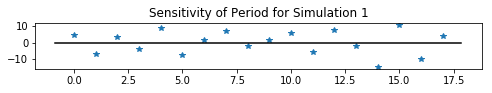

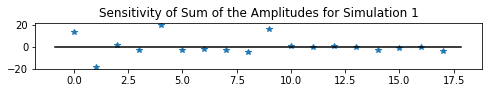

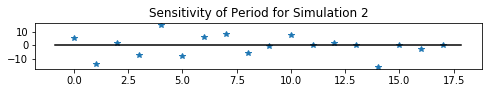

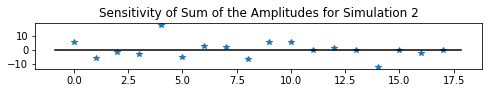

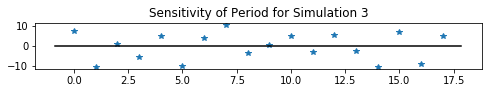

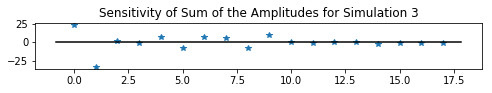

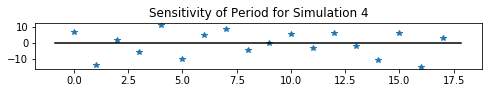

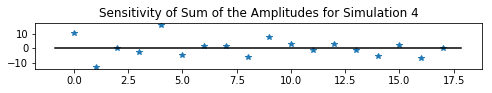

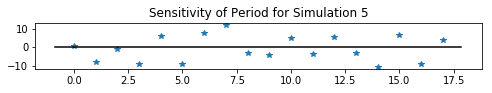

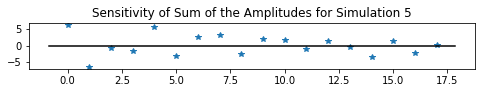

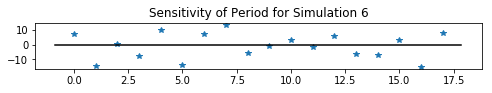

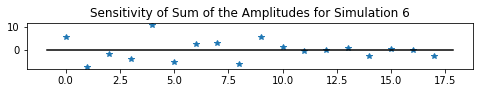

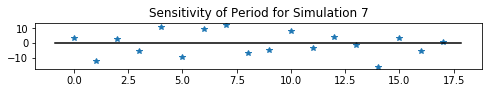

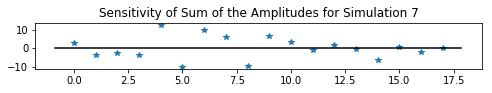

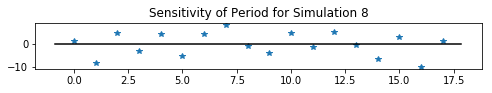

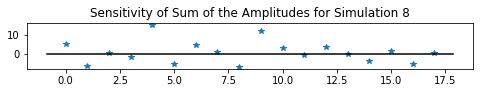

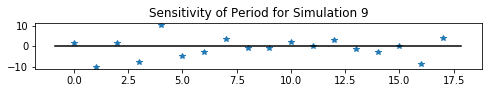

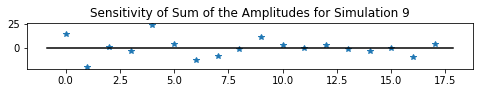

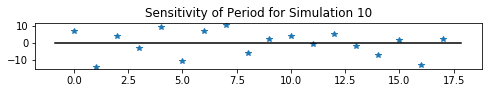

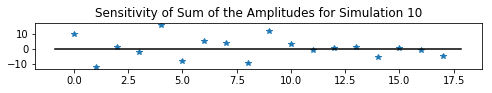

In [20]:
param_names = ['vs','vm','Km','ks','vd','k1','k2','KI', 'Kd', 'n', 'K1', 'K2', 'K3', 'K4', 'V1', 'V2', 'V3', 'V4']
counter = 1

#Analyzes the sensitivity of the amplitude and of the period for each parameter sets.
for runNum in range(0,10):
    
    #Uses the best parameters for each simulation.
    pub_params = [params[runNum][0], params[runNum][1], params[runNum][2], params[runNum][3], params[runNum][4],
                  params[runNum][5], params[runNum][6], params[runNum][7], params[runNum][8], params[runNum][9],
                  params[runNum][10], params[runNum][11], params[runNum][12], params[runNum][13], params[runNum][14],
                  params[runNum][15], params[runNum][16], params[runNum][17]]

    print("Values for Simulation %d" % int(runNum+1))
    
    per = gol95_period(pub_params)
    print("period", per)
    
    #Sum amplitude of the state variables.
    ampTot = gol95_amplitude( pub_params, which_state = -1 )
    print( "amplitude of M+P0+P1+P2+PN", ampTot, "\n")

    #Sensitivity of the period.
    Srel = sensitivity(gol95_period, np.array(pub_params), 0.05)
    plt.figure(figsize=(8,20))
    plt.subplot(20, 1, counter)
    counter += 1
    plt.plot(np.arange(len(pub_params)), Srel, '*')
    plt.plot(plt.xlim(), [0, 0], 'k');
    plt.xticks(ticks=np.arange(len(param_names)), labels=param_names);
    plt.title("Sensitivity of Period for Simulation %d" % int(runNum +1));

    #Sensitivity of the amplitude.
    Srel = sensitivity(lambda p: gol95_amplitude(p, which_state = -1), np.array(pub_params), 0.05)
    plt.figure(figsize=(8,20))
    plt.subplot(20, 1, counter)
    counter += 1
    plt.plot( np.arange(len(pub_params)), Srel, '*')
    plt.plot(plt.xlim(), [0, 0], 'k');
    plt.xticks(ticks=np.arange(len(param_names)), labels=param_names);
    plt.title("Sensitivity of Sum of the Amplitudes for Simulation %d" % int(runNum+1));

Across the 10 simulations, we noticed that the period of the Gol95 model is most sensitive to the parameters KI and v1. We also noticed that vm also has a similar impact with lower frequency. Furthermore the parameters vd and v3 have some lower impact compared to previously mentioned parameters. For example, simulations 7 and 8 show how KI and v1 are particularly sensitive and simulations 2 and 10 show how vm has moderate impact. Simulation 2, 4, 6, and 9 demonstrate the effect of parameters vd and v3. Their sensitivities all lie around the range of 0-10 (absolute value). In terms of sum of amplitudes for the Gol95 model, we notice that the parameter vd generally has the highest impact on the sum of amplitudes. Additionally, vm consistently has a high impact but with less frequency. For example, in simulations 1 and 6 parameter vd has a strong effect on the sum of amplitudes and simulations 4, 9, and 10 show that parameter vm has high impact. Overall, the extent of sensitivies range around 0-10 (absolute value) with the exception being the range of around 0-25 (absolute) being the largest range in simulations 3 and 9 and the range around 0-5 (absolute) being the smallest range in simulation 5. Moreover, there are some places where parameters have opposite effects with high sensitivity and low sensitivity  in different simulations. For example, in simulations 1 and 2 for the period, the parameter V2 exemplifies this occurrence with V2 being about 10 and then about 0, and for the amplitude, the parameter V1 exemplifies this occurrence with V1 being about 3 and then about 11. 

# Extension for Sensitivity of M and PN


Values for Simulation 1
amplitude of M 0.36373826385058966
amplitude of PN 0.27180443328401405

Values for Simulation 2
amplitude of M 1.4782730673003521
amplitude of PN 1.3899671664417623

Values for Simulation 3
amplitude of M 0.7153765527523779
amplitude of PN 0.4014671931088809

Values for Simulation 4
amplitude of M 1.422509950505813
amplitude of PN 0.7602691037932838

Values for Simulation 5
amplitude of M 1.375944791547277
amplitude of PN 0.7962528915167322

Values for Simulation 6
amplitude of M 0.7601076057282004
amplitude of PN 0.5962461256717084

Values for Simulation 7
amplitude of M 0.28745048283358066
amplitude of PN 0.5032499903602548

Values for Simulation 8
amplitude of M 0.2907533140759676
amplitude of PN 0.24640175873996473

Values for Simulation 9
amplitude of M 1.2929580615156246
amplitude of PN 0.679845194646868

Values for Simulation 10
amplitude of M 1.168786913728079
amplitude of PN 0.8128512234809393


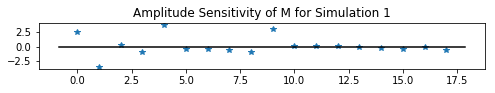

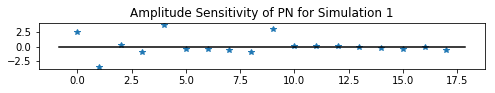

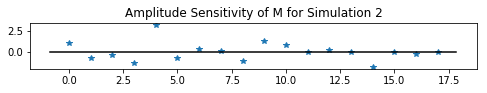

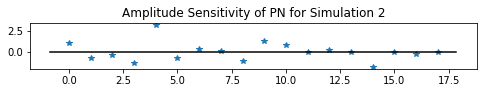

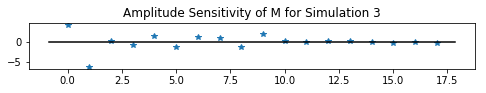

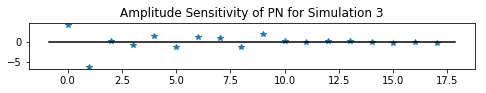

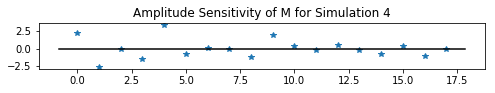

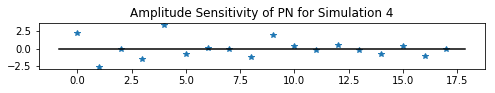

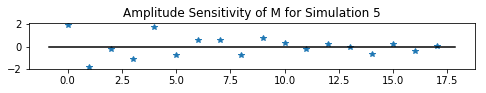

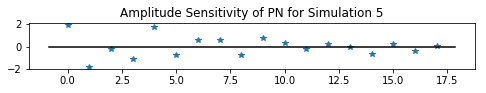

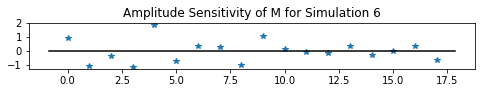

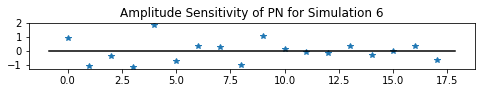

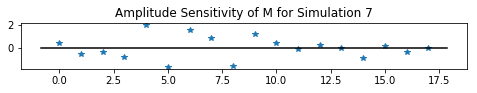

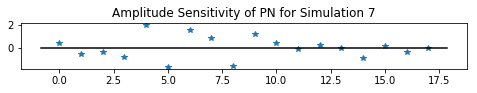

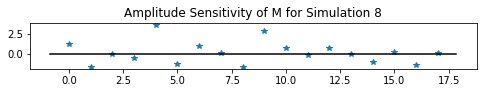

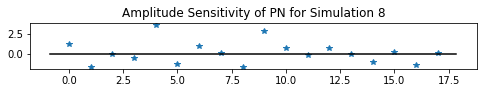

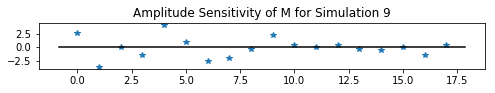

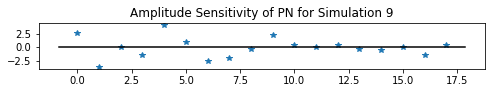

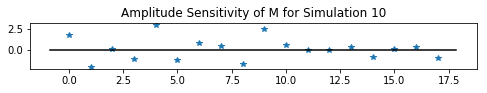

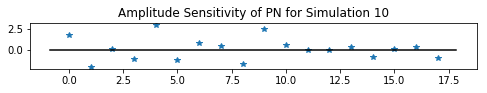

In [33]:
param_names = ['vs','vm','Km','ks','vd','k1','k2','KI', 'Kd', 'n', 'K1', 'K2', 'K3', 'K4', 'V1', 'V2', 'V3', 'V4']
state = 0
count = 1

#Analyzes the sensitivity of the amplitude and of the period for each parameter sets.
for runNum in range(0,10):
    
    #Uses the best parameters for each simulation.
    pub_params = [params[runNum][0], params[runNum][1], params[runNum][2], params[runNum][3], params[runNum][4],
                  params[runNum][5], params[runNum][6], params[runNum][7], params[runNum][8], params[runNum][9],
                  params[runNum][10], params[runNum][11], params[runNum][12], params[runNum][13], params[runNum][14],
                  params[runNum][15], params[runNum][16], params[runNum][17]]

    print("\nValues for Simulation %d" % int(runNum+1))

    #Amplitude for M and PN.
    amp1 = gol95_amplitude(pub_params, which_state = 0)
    print( "amplitude of M", amp1)
    amp2 = gol95_amplitude(pub_params, which_state = 4)
    print( "amplitude of PN", amp2)

    #Sensitivity of the amplitude for M and PN.
    state_names = ["M", "PN"]
    for i in range(len(state_names)):
        Srel = sensitivity(lambda p: gol95_amplitude(p, which_state = state), np.array(pub_params), 0.05)
        state += 4
        plt.figure(figsize=(8,20))
        plt.subplot(20, 1, count)
        count += 1
        plt.plot(np.arange(len(pub_params)), Srel, '*')
        plt.plot(plt.xlim(), [0, 0], 'k');
        #plt.xticks(ticks=np.arange(len(param_names)), labels=param_names);
        plt.title("Amplitude Sensitivity of %s for Simulation %d" % (state_names[i], int(runNum+1)))
        state = 0

We looked at the state variables M and PN over the course of 10 simulations for the Gol95 model. We saw that the state variabes M and PN are most sensitive to the parameter vd. For example, the simulations 6, 7, and 8 demonstrate that the parameter vd has the most impact on M and PN. Following after vd, we noticed that the parameter vm has a significant impact on M and PN but with less frequency. Interestingly in simulation 7, the state variables M and PN are very sensitive to the paramaters k1 and Kd despite these variables not having as much of a significant impact on the other simulations. In general, the paramaters range approximately between 0-4 (absolute value) but at simulation 3, the state variables M and PN are extremely sensitive to changes in vm which ranges between 0 and 7 (absolute). Moreover, there are some places where parameters have opposite effects with high sensitivity and low sensitivity  in different simulations. For example, in simulations 2 and 3 for M, the parameters vm and V1 exemplifies this occurrence with vm being about 1 and then about 6 and with V1 being about -2.5 and then 0. For PN, the parameters vd and V1 exemplifies this occurrence with vd being about 2.5 and then about 1 and with V1 being about 2.5 and 0. 

# Extension: Analyze Goodwin Model

In [ ]:
def goodwin_oscillator( t, statevars, params ):
    X = statevars[0];
    Y = statevars[1];
    Z = statevars[2];
    alpha_1 = params[0]
    K = params[1]
    n = params[2]
    gamma_1 = params[3]
    alpha_2 = params[4]
    gamma_2 = params[5]
    alpha_3 = params[6]
    gamma_3 = params[7]
        
    dydt = np.zeros( (3,) )
    dydt[0] = alpha_1*K**n/(K**n+Z**n) - gamma_1*X
    dydt[1] = alpha_2*X - gamma_2*Y;
    dydt[2] = alpha_3*Y - gamma_3*Z;

    return dydt

def simulate_goodwin( params, t0=0, tStop=240, dt=0.1 ):
    yinit = np.ones((3,));
    goodwin = lambda t, y: goodwin_oscillator(t, y, params)
    sol = scipy.integrate.solve_ivp(fun=goodwin, t_span=(0,10*24), y0=yinit, method='RK45', 
                                    t_eval=np.arange(0,10*24,0.1) )
    sol = scipy.integrate.solve_ivp(fun=goodwin, t_span=(0,10*24), y0=sol.y[:,-1], method='RK45', 
                                    t_eval=np.arange(t0,tStop,dt), rtol=1e-8 )

    return sol

def goodwin_period( params ):
    sol = simulate_goodwin( params )
    (per,sdper) = get_period(sol.y[0,:], sol.t)
    return per

def goodwin_amplitude( params, which_state=-1 ):
    """ Return the amplitude of the given state or of the sum of all three states
        If which_state  == -1, then return the sum of all 3.
        Otherwise, which_state should be 0 (for M), 1 (for P), or 2 (for I)
    """
    sol = simulate_goodwin(params)
    if which_state == -1:
        return np.sum(sol.y.max(axis=1)-sol.y.min(axis=1))
    else:
        return sol.y[which_state,:].max() - sol.y[which_state,:].min()

In [ ]:
#Runs the GA for tournament selection operator with size 5.
#Runs the algorithm 10 times and saves the results in .npz files.
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 6;
settings.eliteCount = 1;
settings.selection = 'tournament';
settings.tournamentSize = 5;

for runNum in range(1,11):
    fn = "Goodwin_tournament%d_run%d.npz" % (settings.tournamentSize,runNum)
    if os.path.isfile(fn):
        continue

    (params, cost, all_params, all_costs, mean_gen_cost, median_gen_cost) = GA(gol95_cost, lb, ub, settings);
    np.savez( fn, params=params, cost=cost, all_params=all_params, all_costs=all_costs, mean_gen_cost=mean_gen_cost)

In [14]:
tournamentSize = 5

params = []

#Reads in the data from the simulations.
for runNum in range(1,11):
    fn = "Goodwin_tournament%d_run%d.npz" %(tournamentSize,runNum)
    f = np.load( fn, allow_pickle=True )
    params.append(f['params'])

Values for Simulation 1
period 2.88125
amplitude of alpha_1+K+n+gamma_1+alpha_2+gamma_2+alpha_3+gamma_3 0.0001810575237056189 

Values for Simulation 2
period 2.00940170940171
amplitude of alpha_1+K+n+gamma_1+alpha_2+gamma_2+alpha_3+gamma_3 0.00027638840458860114 

Values for Simulation 3
period 2.9274999999999998
amplitude of alpha_1+K+n+gamma_1+alpha_2+gamma_2+alpha_3+gamma_3 0.0001420541833016542 

Values for Simulation 4
period 2.8725
amplitude of alpha_1+K+n+gamma_1+alpha_2+gamma_2+alpha_3+gamma_3 0.0015761543053782745 

Values for Simulation 5
period 1.7338235294117648
amplitude of alpha_1+K+n+gamma_1+alpha_2+gamma_2+alpha_3+gamma_3 0.0002873906316274988 

Values for Simulation 6
period 2.562637362637363
amplitude of alpha_1+K+n+gamma_1+alpha_2+gamma_2+alpha_3+gamma_3 0.00010277963102631182 

Values for Simulation 7
period 1.4980891719745222
amplitude of alpha_1+K+n+gamma_1+alpha_2+gamma_2+alpha_3+gamma_3 0.00027238196595154307 

Values for Simulation 8
period 1.9322314049586777


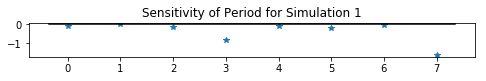

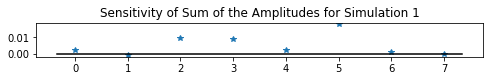

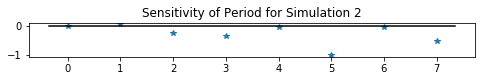

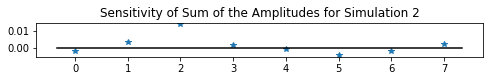

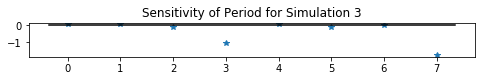

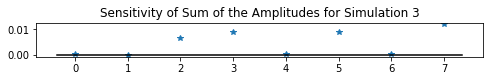

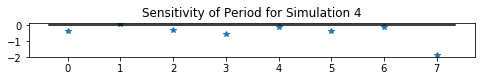

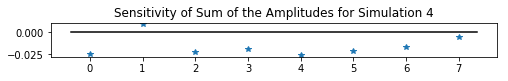

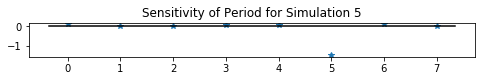

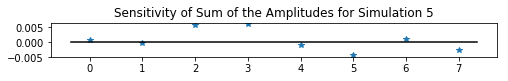

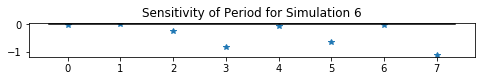

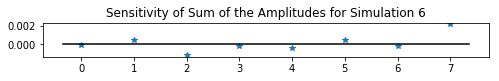

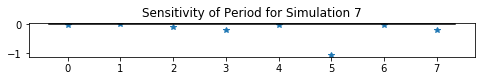

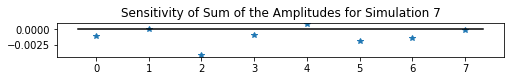

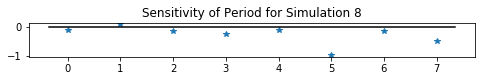

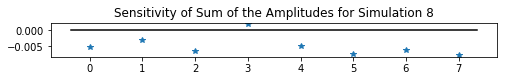

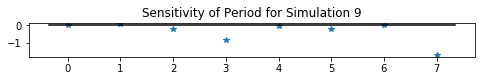

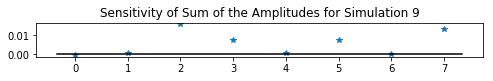

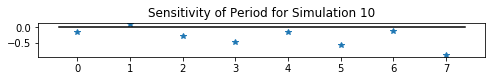

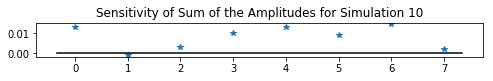

In [15]:
param_names = ['alpha_1','K','n','gamma_1','alpha_2','gamma_2','alpha _3','gamma_3']
counter = 1

#Analyzes the sensitivity of the amplitude and of the period for each parameter sets.
for runNum in range(0,10):
    
    #Uses the best parameters for each simulation.
    pub_params = [params[runNum][0], params[runNum][1], params[runNum][2], params[runNum][3], params[runNum][4],
                  params[runNum][5], params[runNum][6], params[runNum][7]]

    print("Values for Simulation %d" % int(runNum+1))
    
    per = goodwin_period(pub_params)
    print("period", per)
    
    #Sum amplitude of the state variables.
    ampTot = goodwin_amplitude( pub_params, which_state = -1 )
    print( "amplitude of alpha_1+K+n+gamma_1+alpha_2+gamma_2+alpha_3+gamma_3", ampTot, "\n")

    #Sensitivities for period.
    Srel = sensitivity(goodwin_period, np.array(pub_params), 0.05)
    plt.figure(figsize=(8,15))
    plt.subplot(20, 1, counter)
    counter += 1
    plt.plot( np.arange(len(pub_params)), Srel, '*')
    plt.plot(plt.xlim(), [0, 0], 'k');
    #plt.xticks(ticks=np.arange(len(param_names)), labels=param_names);
    plt.title("Sensitivity of Period for Simulation %d" % int(runNum+1));
    
    #Sensitivities for amplitude.
    Srel = sensitivity(lambda p: goodwin_amplitude(p, which_state = -1), np.array(pub_params), 0.05)
    plt.figure(figsize=(8,15))
    plt.subplot(20, 1, counter)
    counter += 1
    plt.plot( np.arange(len(pub_params)), Srel, '*')
    plt.plot(plt.xlim(), [0, 0], 'k');
    plt.xticks(ticks=np.arange(len(param_names)), labels=param_names);
    plt.title("Sensitivity of Sum of the Amplitudes for Simulation %d" % int(runNum+1));

Over the course of 10 simulations with different paramater sets, paramaters gamma 1, gamma 2, and gamma 3 have more of a significant impact on the period of the Goodwin oscillator. Specifically, the Goodwin oscillator's period is generally most sensitive to gamma 3, followed by moderate sensitivity to gamma 1. Occasionally, the Goodwin oscillator's period is most impacted by gamma 2. When gamma 3 has a high impact on the period of the Goodwin oscillator, gamma 2 typically has a lower impact on the period. For example, in Simulations 1 and 3, gamma 3 has the most impact with gamma 1 having a moderate impact and gamma 2 having a lower impact on the period. In Simulation 5 and 7, gamma 2 has the most impact. Overall, we noticed that parameters alpha 1, K, n, alpha 2, and alpha 3 all have very minimal effect on the Goodwin oscillator's period. When considering the intensity of the sensitivities of the parameters, we noticed that the extent of impact usually ranges between 0-2 (absolute value) with the exception of simulation 10 which has a particularly small intensity with a range of 0-1 (absolute value). As for amplitude, parameters n, gamma 1, gamma 2, and gamma 3 generally have more significant impact on the Goodwin oscillator's sum of amplitudes for each state variable. Overall, we found that paramater n and gamma 3 have the most impact on the Goodwin oscillator. For example in simulation 9, we see that paramaters n and gamma 3 have the most significant impact compared to the rest of the paramaters. When considering the intensity of sensitivities of sum of amplitudes, the extent of impact typically ranges between 0-0.025 which is fairly low but the exception lies with simulation 5 and 8 which ranges between 0-0.005 and simulation 6 which has a range between 0-0.002 which are extremely low. Moreover, there are some places where parameters have opposite effects with high sensitivity and low sensitivity in different simulations. For example, in simulations 1 and 2 for period, the parameter gamma 2 exemplifies this occurrence with gamma 2 being about 0 and then about 1. For amplitude, the parameter gamma 2 exemplifies this occurrence with gamma 2 being about 0.015 and then about 0.005.

<hr style="border:2px solid gray"> </hr>

Acknowledgements

*Thanks to help from Stephanie in office hours.*